In [1]:
import librosa
from pydub import AudioSegment
from os import path
import pandas as pd

import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import librosa.display
import math
import pickle
import os

In [ ]:
pd.show_versions()

In [2]:
from utils import convert_to_spectogram,  slice_audio,  process_audio,  process_dataset,  read_file_and_resample, predict_using_model

# Preprocessing

## Overview

(32, 130)


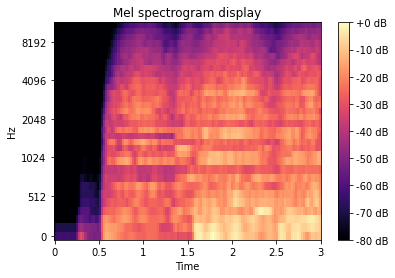

In [226]:
file_path = "./data/classical/Beethoven - 5th Symphony, Op. 67 (Excerpt).mp3"
samples = read_file_and_resample(file_path)

slices = slice_audio(samples)

section = slices[0]
M_db = convert_to_spectogram(section, normalize=False)

print(M_db.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")

## Reading files into a dataset

In [140]:
# class_names = ['classical_test']
class_names = os.listdir('./data')
data_set = []
for class_id in range(len(class_names)):
    for file_name in os.listdir('./data/' + class_names[class_id]):
        file_path = os.path.join('./data', class_names[class_id], file_name)

        try:
            print("Attempting to read file: ", file_path)
            data = read_file_and_resample(file_path)
            data_set.append((file_path, data, class_id))
        except:
            print('error occured reading the file: ', file_path)

with open('data.pickle', 'wb') as f:
    pickle.dump(data_set, f, pickle.HIGHEST_PROTOCOL)

Attempting to read file:  ./data\classical\Alexander Faris - Loveliest Upstairs Downstairs theme music.mp3


c:\Users\Aziz\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Attempting to read file:  ./data\classical\Bach - Orchestral Suite #3 In D, BWV 1068 - Air On A G String.mp3
Attempting to read file:  ./data\classical\Bach - Violin Concerto No. 1 in A Minor.mp3
error occured reading the file:  ./data\classical\Bach - Violin Concerto No. 1 in A Minor.mp3
Attempting to read file:  ./data\classical\Beethoven - 5th Symphony, Op. 67 (Excerpt).mp3
Attempting to read file:  ./data\classical\Beethoven - Lisista - Fur Elise.mp3
Attempting to read file:  ./data\classical\Beethoven - Symphony #3.mp3
Attempting to read file:  ./data\classical\Berlioz - Rakoczy March.mp3
Attempting to read file:  ./data\classical\Bethoven - Moonlight Sonata.mp3
Attempting to read file:  ./data\classical\Bethoven - Symphony 6.mp3
Attempting to read file:  ./data\classical\Bizet - Carmen - Overture.mp3
Attempting to read file:  ./data\classical\Bizet - Habanera.mp3
Attempting to read file:  ./data\classical\Bizet - Micaela_s Air-Carmen.mp3
Attempting to read file:  ./data\classical

In [3]:
f = open('data.pickle', 'rb')
restored_data = pickle.load(f)

In [4]:
file_paths = [file_name for (file_name, data, label) in restored_data]
labels = [label for (file_name, data, label) in restored_data]
wavedata = [data for (file_name, data, label) in restored_data]
df = pd.DataFrame({'file_path': file_paths, 'wavedata': wavedata, 'label': labels})

## Converting dataset into spectrograms

In [5]:
train_val_dataset, test_dataset = train_test_split(df, test_size=0.1, random_state=123)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.1, random_state=123)

test_df = process_dataset(test_dataset)

train_df = process_dataset(train_dataset)
val_df = process_dataset(val_dataset)


# with open('train_df.pickle', 'wb') as f:
#     pickle.dump(train_df, f, pickle.HIGHEST_PROTOCOL)
# with open('val_df.pickle', 'wb') as f:
#     pickle.dump(val_df, f, pickle.HIGHEST_PROTOCOL)
# with open('test_df.pickle', 'wb') as f:
#     pickle.dump(test_df, f, pickle.HIGHEST_PROTOCOL)

In [3]:
with open('train_df.pickle', 'rb') as f:
    train_df = pickle.load(f)

with open('val_df.pickle', 'rb') as f:
    val_df = pickle.load(f)

with open('test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

In [5]:
X_train, y_train = np.array([np.array(
    spectrogram) for spectrogram in train_df['spectrogram']]), train_df['label']
X_val, y_val = np.array([np.array(spectrogram)
                        for spectrogram in val_df['spectrogram']]), val_df['label']
X_test, y_test = np.array([np.array(spectrogram)
                          for spectrogram in test_df['spectrogram']]), test_df['label']

## Survey of traditional ML methods

In [199]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

X_train_columns = pd.DataFrame(X_train.reshape(len(X_train), 4160))

lin_classifier = SGDClassifier()
lin_classifier.fit(X_train_columns, y_train)

X_test_columns = pd.DataFrame(X_test.reshape(len(X_test), 4160))
y_pred = lin_classifier.predict(X_test_columns)

accuracy_score(y_test, y_pred)


SGDClassifier()

In [203]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_columns, y_train)

y_pred = knn_classifier.predict(X_test_columns)

accuracy_score(y_test, y_pred)

0.3367231638418079

In [209]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(n_jobs=8)

rand_forest_classifier.fit(X_train_columns, y_train)

y_pred = rand_forest_classifier.predict(X_test_columns)

accuracy_score(y_test, y_pred)

0.6139359698681732

In [210]:
from sklearn.ensemble import BaggingClassifier

bagging_classifier = BaggingClassifier(n_jobs=8)

bagging_classifier.fit(X_train_columns, y_train)

y_pred = bagging_classifier.predict(X_test_columns)

accuracy_score(y_test, y_pred)

0.5661016949152542

In [212]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_classifier = AdaBoostClassifier(n_estimators=200)

ada_boost_classifier.fit(X_train_columns, y_train)

y_pred = ada_boost_classifier.predict(X_test_columns)

accuracy_score(y_test, y_pred)


0.527306967984934

## CNN model

In [8]:

model = keras.models.Sequential([
    keras.layers.RandomRotation(0.1, input_shape=[32, 130, 1]),
    keras.layers.RandomZoom(-.2, .2),
    keras.layers.Conv2D(64, 5, activation="relu", padding="same"),
    keras.layers.Conv2D(64, 5, activation="relu", padding="same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, 5, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 5, activation="relu", padding="same"),
    keras.layers.AveragePooling2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 32, 130, 1)       0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 32, 130, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 32, 130, 64)       1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 130, 64)       102464    
                                                                 
 average_pooling2d (AverageP  (None, 16, 65, 64)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 16, 65, 64)      

### Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [ModelCheckpoint(filepath='best_model_colab.h5', monitor='val_loss', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=100)]

history = model.fit(X_train, y_train, epochs=1000,
                    callbacks=callbacks,  # Early stopping
                    validation_data=(X_val, y_val))

### Loading a model

In [3]:
loaded_model = keras.models.load_model('./best_model_colab.h5')

### Model Evaluation

#### Evaluation of per-slice accuracy

In [ ]:
loaded_model.evaluate(X_test, y_test)

#### Evaluation of voting method

In [137]:
test_songs = []
for file_path in test_df['file_path'].unique():
    test_songs.append(test_df[test_df['file_path'] == file_path])
    
predictions = []
true_labels = []

for song_df in test_songs:
    correct_label = song_df.values[0][3]
    final_prediction = predict_using_model(
        [section_row[2] for section_row in song_df.values], loaded_model)
    
    predictions.append(final_prediction)
    true_labels.append(correct_label)

3/3 [==============================] - 1s 247ms/step


In [138]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, labels=range(len(class_names)), target_names=class_names))

              precision    recall  f1-score   support

   classical       1.00      0.83      0.91        12
     country       1.00      0.89      0.94         9
      hiphop       1.00      1.00      1.00        11
        jazz       0.75      0.60      0.67         5
        rock       0.73      1.00      0.85        11

    accuracy                           0.90        48
   macro avg       0.90      0.86      0.87        48
weighted avg       0.91      0.90      0.90        48



##### Checking for patterns in misidentified data
We can see that when model misidentifies it does so for the vast majority of the slices

In [220]:
bad_preds = []
for pred_id in range(len(predictions)):
    if true_labels[pred_id] != predictions[pred_id]:
        print(song.values[0][0])
        print("True label: ", true_labels[pred_id])
        song = test_songs[pred_id]
        correct_label = song_df.values[0][3]
        final_prediction = predict_using_model([section_row[2] for section_row in song_df.values], loaded_model, verbose = 1)
        bad_preds.append(song)
        print("\n")
        


./data\country\011. Willie Nelson - Blue Eyes Crying In the Rain.mp3
True label:  0.0
3/3 [==============================] - 1s 245ms/step
Slice predictions:  [4 4 4 3 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 4]
Cumul. Prediction, Labels predicted, Labels frequency
4 [0 3 4] [ 2  3 66]


./data\classical\Berlioz - Rakoczy March.mp3
True label:  3.0
3/3 [==============================] - 1s 293ms/step
Slice predictions:  [4 4 4 3 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 4]
Cumul. Prediction, Labels predicted, Labels frequency
4 [0 3 4] [ 2  3 66]


./data\jazz\94. Tony Bennett - As Time Goes By.mp3
True label:  0.0
3/3 [==============================] - 1s 255ms/step
Slice predictions:  [4 4 4 3 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

## Predicting an individual song

In [4]:
file_path = "Sierra Ferrell - Hey Me, Hey Mama (Official Audio).mp3"
samples, sr = librosa.load(file_path)

slices = slice_audio(samples)

X = [convert_to_spectogram(section) for section in slices]

predict_using_model(X, loaded_model, verbose = 1)

3/3 [==============================] - 1s 131ms/step
Slice predictions:  [1 1 1 2 2 1 3 1 3 3 1 3 1 1 1 1 3 1 1 1 1 1 1 3 3 3 3 2 3 1 1 1 1 3 1 1 1
 1 3 1 1 1 1 1 4 1 3 3 3 1 1 1 1 3 2 2 1 1 1 1 3 1 1 3 1 2 3 1 3 3]
Cumul. Prediction, Labels predicted, Labels frequency
1 [1 2 3 4] [42  6 21  1]


1